<a href="https://colab.research.google.com/github/VanHoann/Yelp_Dataset_Challenges/blob/main/Recommendation_Prediction/Legacy/Ratings_Prediction_Wide_and_Deep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

In [1]:
import os
from collections import Counter
from itertools import combinations
import random
import numpy as np
import pandas as pd
import tensorflow 
from tensorflow.keras.layers import Concatenate, Dense, Dot, Dropout, Embedding, Input, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
import keras
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler #normalize some features

# Setting random seeds to replicate results easily
random.seed(0)
np.random.seed(0)
tensorflow.random.set_seed(0)

## Metric (RMSE)
RMSE is used to evaluate the performance of a model. *A* lower RMSE indicates a better model

In [2]:
def rmse(pred, actual):
    '''
    params:
        pred <np.array>: an array containing all predicted ratings
        actual <np.array>: an array containing all ground truth ratings

    return:
        a scalar whose value is the rmse
    '''
    # Ignore ratings with value zero.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return np.sqrt(mean_squared_error(pred, actual))

## Wide and Deep Learning (WDL)
Two parts: "Wide" and "Deep"

**Wide:** a generalized linear model \
Input: raw input features + the cross-product transformation of categorical features \
-> **learn the co-occurrence patterns of items or features**

**Deep:** a Feed-forward Neural Network (FNN) \
Input: continuous (normalized) and (concatenate) categorical features (low-dim dense embedding vectors) \
-> feed this concatenated vector into the FNN during each foward pass -> **increase the diversity of recommendations**

# Data Preprocessing
Utility functions that helps us retrieve the numerical values of different features from the dataset, and generate combinations of features to be used by the WDL model.

### Retrieve cont_feats

In [3]:
def get_continuous_features(df, continuous_columns):
    '''
    params:
        df: input dataframe
        continuous_columns: column names of continuous features

    return: 
        a numpy array where each row contains the values of continuous features in the corresponding row of the input dataframe
    '''
    continuous_features = df[continuous_columns].values
    return continuous_features

### Cate_feats cross_prod transform
This func generates frequently-occured feature combinations

E.g: `['A, B, C, D', 'A, B, C', 'A, B', 'A']`

|Item Name|Occurrence|
|---|---|
|A|4|
|B|3|
|C|2|
|D|1|

Set `topk=3` -> use only top 3 frequent items to generate combinations

Set `comb_p=2` -> generate combinations with 2 items/combination

In this case, the following combinations will be generated: `[('A', 'B'), ('A', 'C'), ('B', 'C')]`



In [5]:
def get_top_k_p_combinations(df, comb_p, topk, output_freq=False):
    '''
    params:
        df: input dataframe
        comb_p: number of elements in each combination (e.g., there are two elements in the combination {fried chicken, chicken and waffle}, and three elements in the combination {fried chicken, chicken and waffle, chicken fried rice})
        topk: number of most frequent combinations to retrieve
        output_freq: whether to return the frequencies of retrieved combinations

    return:
        1. output_freq = True: a list X where each element is a tuple containing a combination tuple and corresponding frequency, and the elements are stored in the descending order of their frequencies
        2. output_freq = False: a list X where each element is a tuple containing a combination tuple, and the elements are stored in the descending order of their frequencies
    '''
    def get_category_combinations(categories_str, comb_p=2):
        categories = categories_str.split(', ')
        return list(combinations(categories, comb_p))
        
    all_categories_p_combos = df["item_categories"].apply(lambda x: get_category_combinations(x, comb_p)).values.tolist()
    all_categories_p_combos = [tuple(t) for item in all_categories_p_combos for t in item]
    tmp = dict(Counter(all_categories_p_combos))
    sorted_categories_combinations = list(sorted(tmp.items(), key=lambda x: x[1], reverse=True))
    if output_freq:
        return sorted_categories_combinations[:topk]
    else:
        return [t[0] for t in sorted_categories_combinations[:topk]]

#test code
get_top_k_p_combinations(pd.DataFrame({'item_categories': ['A, B, C, D', 'A, B, C', 'A, B', 'A']})
  , comb_p=2, topk=3, output_freq=True) 


[(('A', 'B'), 3), (('A', 'C'), 2), (('B', 'C'), 2)]

### Build wide_feats

In [6]:
def get_wide_features(df, selected_categories_to_idx, top_combinations):
    '''
    params:
        df: input dataframe
        selected_categories_to_idx: a dictionary mapping item categories to corrresponding integral indices
        top_combinations: a list containing retrieved mostly frequent combinantions of item categories

    return:
        a numpy array where each row contains the categorical features' binary encodings and cross product transformations for the corresponding row of the input dataframe
    '''
    def categories_to_binary_output(categories): # "A, B, C" - len=1
        binary_output = [0 for _ in range(len(selected_categories_to_idx))] # [0,0,...0] = dict_size
        for category in categories.split(', '): # "A", "B", "C"
            if category in selected_categories_to_idx:
                binary_output[selected_categories_to_idx[category]] = 1 # 0to1 for "A", "B", "C"
            else:
                binary_output[0] = 1 #map all unk to index 0
        return binary_output

    def categories_cross_transformation(categories): # {A,B}, {A,C,D},... - len>1
        current_category_set = set(categories.split(', ')) 
        cross_transform_output = [0 for _ in range(len(top_combinations))]
        for k, comb_k in enumerate(top_combinations):
            if len(current_category_set & comb_k) == len(comb_k):
                cross_transform_output[k] = 1
            else:
                cross_transform_output[k] = 0
        return cross_transform_output

    category_binary_features = np.array(df.item_categories.apply(lambda x: categories_to_binary_output(x)).values.tolist())
    category_cross_transform_features = np.array(df.item_categories.apply(lambda x: categories_cross_transformation(x)).values.tolist())
    return np.concatenate((category_binary_features, category_cross_transform_features), axis=1)

## Load train, valid, test data (core)

In [10]:
data = "https://raw.githubusercontent.com/VanHoann/Yelp_Dataset_Challenges/main/Recommendation_Prediction/data"
tr_df = pd.read_csv(f"{data}/train.csv")
val_df = pd.read_csv(f"{data}/valid.csv")
te_df = pd.read_csv(f"{data}/test.csv")

tr_ratings = tr_df['stars'].values
val_ratings = val_df['stars'].values

In [13]:
print(tr_df.shape, val_df.shape, te_df.shape)
print(tr_df[:1])

(60080, 3) (7509, 3) (7509, 3)
                            user_id                       business_id  stars
0  7cf33b34bb6ffe993c5f208222860eb3  16d09ff5f22e701e1b729b74f565f825    4.0


## Load users and items (supplement)

In [14]:
user_df = pd.read_csv(f"{data}/full_user.csv", index_col=0)
item_df = pd.read_csv(f"{data}/full_business.csv")

In [15]:
# Renaming columns by adding prefixes to column names
user_df = user_df.rename(index=str, columns={t: 'user_' + t for t in user_df.columns if t != 'user_id'})
item_df = item_df.rename(columns={t: 'item_' + t for t in item_df.columns if t != 'business_id'})

### Convert item_df's cols to numerical if needed

In [18]:
item_df.columns

Index(['item_address', 'business_id', 'item_categories', 'item_city',
       'item_is_open', 'item_latitude', 'item_longitude', 'item_name',
       'item_postal_code', 'item_review_count', 'item_stars', 'item_state',
       'item_Sunday_Open', 'item_Sunday_Close', 'item_Monday_Open',
       'item_Monday_Close', 'item_Tuesday_Open', 'item_Tuesday_Close',
       'item_Wednesday_Open', 'item_Wednesday_Close', 'item_Thursday_Open',
       'item_Thursday_Close', 'item_Friday_Open', 'item_Friday_Close',
       'item_Saturday_Open', 'item_Saturday_Close', 'item_NoiseLevel',
       'item_RestaurantsAttire', 'item_RestaurantsTakeOut',
       'item_RestaurantsReservations', 'item_RestaurantsDelivery',
       'item_Alcohol', 'item_RestaurantsPriceRange2', 'item_BikeParking',
       'item_HappyHour', 'item_OutdoorSeating',
       'item_RestaurantsGoodForGroups', 'item_HasTV', 'item_Caters',
       'item_GoodForKids', 'item_BusinessAcceptsCreditCards', 'item_WiFi',
       'item_GoodForDancing', 'it

In [21]:
to_numerical = ['Parking_Street', 'Parking_Valet', 'Parking_Lot', 'Parking_Garage',
       'Parking_Validated', 'GoodFor_dessert', 'GoodFor_latenight',
       'GoodFor_lunch', 'GoodFor_dinner', 'GoodFor_brunch',
       'GoodFor_breakfast', 'Ambience_romantic', 'Ambience_intimate',
       'Ambience_classy', 'Ambience_hipster', 'Ambience_divey',
       'Ambience_touristy', 'Ambience_trendy', 'Ambience_upscale',
       'Ambience_casual']
#temp = pd.DataFrame(np.zeros((item_df.shape[0], len(to_numerical))), columns=to_numerical)
#item_df = item_df.fillna(temp)

User info

In [22]:
print(user_df.shape)
print(user_df.loc['1'])

(2980, 21)
user_id                    9de9e40b3727c667a5b7c1664aa59a5b
user_name                                             Bobby
user_review_count                                       376
user_yelping_since                      2010-03-10 23:55:33
user_useful                                            1754
user_funny                                             1036
user_cool                                              1124
user_elite                    2013,2014,2015,2016,2017,2018
user_fans                                                39
user_average_stars                                     3.64
user_compliment_hot                                      47
user_compliment_more                                      6
user_compliment_profile                                   2
user_compliment_cute                                      2
user_compliment_list                                      1
user_compliment_note                                     38
user_compliment_plain        

Item info

In [23]:
print(item_df.shape)
item_df.loc[100, :]

(5964, 80)


item_address                                         4740 E Shea Blvd, Ste 104
business_id                                   a278a39aeed8de9e79a9247750bb23f2
item_categories              American (New), Food, Nightlife, Wine Bars, Ba...
item_city                                                              Phoenix
item_is_open                                                                 1
                                                   ...                        
item_BestNights_friday                                                     1.0
item_BestNights_wednesday                                                  0.0
item_BestNights_thursday                                                   0.0
item_BestNights_sunday                                                     1.0
item_BestNights_saturday                                                   1.0
Name: 100, Length: 80, dtype: object

These features will be considered:
* NoiseLevel
* RestaurantsAttire
* RestaurantsTakeOut
* RestaurantsReservations
* RestaurantsDelivery
* Alcohol
* RestaurantsPriceRange2
* BikeParking
* HappyHour
* OutdoorSeating
* RestaurantsGoodForGroups
* HasTV
* Caters
* GoodForKids
* BusinessAcceptsCreditCards
* WiFi
* GoodForDancing
* Smoking
* RestaurantsTableService
* BYOBCorkage
* CoatCheck

-> Create a vocab of possible vals of each feat listed above. \
-> A corresponding id val will map to each val in its vocab. 

Note that not every business has all listed feats \
-> Give NaN to the missing feat of a restaurant and map to index 0 in a feat’s vocabulary. The same was done for the other cate feats.

## Merge core and supplement
Merge train, valid, test data with `user_df` and `item_df` on `user_id` and `business_id`

In [24]:
tr_df = pd.merge(pd.merge(tr_df, user_df, on='user_id'), item_df, on='business_id').reset_index(drop=True)
val_df = pd.merge(pd.merge(val_df, user_df, on='user_id'), item_df, on='business_id').reset_index(drop=True)
te_df = pd.merge(pd.merge(te_df, user_df, on='user_id'), item_df, on='business_id').reset_index(drop=True)

In [25]:
pd.set_option('max_rows', 99999)
pd.set_option('max_colwidth', 400)
pd.describe_option('max_colwidth')
print(tr_df.loc[500,:])

display.max_colwidth : int or None
    The maximum width in characters of a column in the repr of
    a pandas data structure. When the column overflows, a "..."
    placeholder is embedded in the output. A 'None' value means unlimited.
    [default: 50] [currently: 400]
user_id                                                                b1f7069fd5ea3751910d573823e24985
business_id                                                            823a0b2b711bdf5e6f0e6ccd029a0e19
stars                                                                                               3.0
user_name                                                                                           Amy
user_review_count                                                                                  1156
user_yelping_since                                                                  2007-02-07 20:41:39
user_useful                                                                                        1750


## Prepare input

### Deep cont_feats
It is used for Deep model

In [27]:
# Specify the columns containing conitnuous features
user_emo = ['compliment_hot', 'compliment_more', 'compliment_profile', 'compliment_cute', 'compliment_list', 
            'compliment_note', 'compliment_plain', 'compliment_cool',  'compliment_funny',  'compliment_writer', 
            'compliment_photos', 'useful', 'funny', 'cool'] 
user_info = ['review_count', 'fans', 'average_stars']
user_cont = user_info + user_emo[:3]
user_cont = ['user_' + t for t in user_cont]   

item_location = ['latitude', 'longitude']
item_info = ['stars', 'review_count', 'is_open']
item_cont = item_info 
item_cont = ['item_' + t for t in item_cont] 

continuous_columns = user_cont + item_cont
print(continuous_columns)
print("no. cont_feats:", len(continuous_columns))

['user_review_count', 'user_fans', 'user_average_stars', 'user_compliment_hot', 'user_compliment_more', 'user_compliment_profile', 'item_stars', 'item_review_count', 'item_is_open']
no. cont_feats: 9


In [28]:
# Get values of continous features for train/validation/test sets using the utility function defined previously
tr_continuous_features = get_continuous_features(tr_df, continuous_columns)
val_continuous_features = get_continuous_features(val_df, continuous_columns)
te_continuous_features = get_continuous_features(te_df, continuous_columns)
print("raw:",tr_continuous_features[0])

# Standardize each feature by removing the mean of the training samples and scaling to unit variance.
# See https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html for more details.
scaler = StandardScaler().fit(tr_continuous_features)

tr_continuous_features = scaler.transform(tr_continuous_features)
val_continuous_features = scaler.transform(val_continuous_features)
te_continuous_features = scaler.transform(te_continuous_features)
print("normalized:", tr_continuous_features[0])

raw: [ 38.    3.    4.1   1.    0.    0.    3.5 726.    1. ]
normalized: [-0.56083802 -0.28727618  0.73578275 -0.18148716 -0.24348181 -0.176347
 -0.70190376 -0.00243181  0.30306351]


### Deep cate_feats
It is used for deep model only (via embeddings)

In [29]:
# Sepcify column names of deep categorical features
item_location = ["city", "postal_code", "state"]
item_hours = ['Sunday_Open', 'Sunday_Close', 'Monday_Open', 'Monday_Close', 'Tuesday_Open', 'Tuesday_Close', 
              'Wednesday_Open', 'Wednesday_Close','Thursday_Open', 'Thursday_Close', 'Friday_Open', 
              'Friday_Close', 'Saturday_Open', 'Saturday_Close']
item_attributes = ['NoiseLevel', 'RestaurantsAttire', 'RestaurantsTakeOut', 'RestaurantsReservations', 
                 'RestaurantsDelivery', 'Alcohol', 'RestaurantsPriceRange2', 'BikeParking', 'HappyHour', 'OutdoorSeating', 
                 'RestaurantsGoodForGroups', 'HasTV', 'Caters', 'GoodForKids', 'BusinessAcceptsCreditCards', 
                 'WiFi', 'GoodForDancing', 'Smoking', 'RestaurantsTableService', 'BYOBCorkage', 'CoatCheck']
#item_attributes = ["Alcohol", "Caters", "NoiseLevel", "WiFi", 'RestaurantsAttire', 'BusinessAcceptsCreditCards',
#                   'RestaurantsPriceRange2', 'RestaurantsGoodForGroups']
item_Parking = ['Parking_Street', 'Parking_Valet', 'Parking_Lot', 'Parking_Garage', 'Parking_Validated']
item_GoodFor = ['GoodFor_dessert', 'GoodFor_latenight', 'GoodFor_lunch', 'GoodFor_dinner', 
                'GoodFor_brunch', 'GoodFor_breakfast']
item_Ambience = ['Ambience_romantic', 'Ambience_intimate', 'Ambience_classy', 'Ambience_hipster', 
                 'Ambience_divey', 'Ambience_touristy', 'Ambience_trendy', 'Ambience_upscale', 'Ambience_casual']
item_Music = ['Music_dj', 'Music_background_music', 'Music_jukebox', 'Music_live', 'Music_video', 'Music_karaoke']
item_BestNights = ['BestNights_monday', 'BestNights_tuesday', 'BestNights_friday', 'BestNights_wednesday', 
                   'BestNights_thursday', 'BestNights_sunday', 'BestNights_saturday']

item_deep_columns = item_location# + item_Parking + item_GoodFor + item_Ambience
item_deep_columns = ['item_' + t for t in item_deep_columns] + ['business_id']  
print(item_deep_columns)

['item_city', 'item_postal_code', 'item_state', 'business_id']


In [30]:
item_deep_columns

# An array of integers where deep_vocab_lens[i] represents the number of unique values of (i+1)-th deep categorical feature
# Transforming words into indices for each categorical columns
item_deep_vocab_lens = []
for col_name in item_deep_columns:
    # Getting unique values of this deep categorical feature
    unique_values = [item for item in tr_df[col_name].unique() if not item!=item]
    
    # Creating a dictionary to map from unique values to the corresponding index
    vocab = dict(zip(unique_values, range(1, len(unique_values)+1)))
    
    # Getting the number of unique values of this deep categorical features
    item_deep_vocab_lens.append(len(vocab)+1)
    
    # Creating a new column where each entry stores the index of this deep categorical feature's value in the same row
    item_df[col_name + "_idx"] = item_df[col_name].apply(lambda x: vocab[x] if x in vocab else 0)


# Creating a dictionary mapping each business id to corresponding values of deep categorical features ('business_id' -> ['item_city_idx', 'item_postal_code_idx', 'item_state_idx'] in this case)
item_deep_idx_columns = [t + "_idx" for t in item_deep_columns] #rename
item_to_deep_categorical_features = dict(zip(item_df['business_id'].values, item_df[item_deep_idx_columns].values.tolist()))

# Creating numpy arrays storing corresponding deep categorical features' values of train/validation/test sets using the above mapping
tr_deep_categorical_features = np.array(tr_df['business_id'].apply(lambda x: item_to_deep_categorical_features[x]).values.tolist())
val_deep_categorical_features = np.array(val_df['business_id'].apply(lambda x: item_to_deep_categorical_features[x]).values.tolist())
te_deep_categorical_features = np.array(te_df['business_id'].apply(lambda x: item_to_deep_categorical_features[x]).values.tolist())

In [31]:
print("unique vals for", len(item_deep_vocab_lens), "chosen items:", item_deep_vocab_lens)

unique vals for 4 chosen items: [118, 799, 14, 5939]


In [32]:
print(item_df.loc[1000,:]) #add indexes (look up from dict)

item_address                                                                   115 E Baseline Rd, Ste 5
business_id                                                            a22b5a31db102b01af2a3fb20fb73440
item_categories                    Restaurants, Barbeque, Hot Dogs, Caterers, Event Planning & Services
item_city                                                                                         Tempe
item_is_open                                                                                          1
item_latitude                                                                                 33.377744
item_longitude                                                                               -111.93823
item_name                                                                                     Tom's BBQ
item_postal_code                                                                                  85283
item_review_count                                               

In [33]:
print(len(list(item_to_deep_categorical_features.items()))) # = no. items
print(list(item_to_deep_categorical_features.items())[50:51]) #each item: (feats_indexes

5964
[('a89a48be9fb0f95db7647fdff62bb312', [25, 163, 3, 2934])]


In [34]:
print(len(tr_deep_categorical_features)) #= no. train data
print(tr_deep_categorical_features[:5]) # near data have the same value
tr_deep_categorical_features[[500,1000,1500,2000]] #3feats for each busID

60080
[[1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]]


array([[  1,   7,   1,  24],
       [  1,  23,   1,  64],
       [  1,  15,   1,  98],
       [  1,   7,   1, 140]])

####user deep

In [35]:
# Sepcify column names of deep categorical features
user_deep_columns = ["user_id"]

# An array of integers where deep_vocab_lens[i] represents the number of unique values of (i+1)-th deep categorical feature
user_deep_vocab_lens = []

for col_name in user_deep_columns:
    # Get all unique values of this deep categorical feature
    tmp = user_df[col_name].unique()
    
    # Create a dictionary mapping each unique value to a unique integral index
    vocab = dict(zip(tmp, range(1, len(tmp) + 1)))
    
    # Get the number of unique values of this deep categorical features
    user_deep_vocab_lens.append(len(vocab) + 1)
    
    # Create a new column where each entry stores the integral index of this deep categorical feature's value in the same row
    user_df[col_name + "_idx"] = user_df[col_name].apply(lambda x: vocab[x])


# Create a dictionary mapping each business id to corresponding values of deep categorical features
user_deep_idx_columns = [t + "_idx" for t in user_deep_columns]
user_to_deep_categorical_features = dict(zip(user_df.user_id.values, user_df[user_deep_idx_columns].values.tolist()))

tr_deep_categorical_features = np.array(tr_df.apply(lambda row: item_to_deep_categorical_features[row.business_id] + user_to_deep_categorical_features[row.user_id], axis=1).values.tolist())
val_deep_categorical_features = np.array(val_df.apply(lambda row: item_to_deep_categorical_features[row.business_id] + user_to_deep_categorical_features[row.user_id], axis=1).values.tolist())
te_deep_categorical_features = np.array(te_df.apply(lambda row: item_to_deep_categorical_features[row.business_id] + user_to_deep_categorical_features[row.user_id], axis=1).values.tolist())

In [36]:
print("unique vals for", len(user_deep_vocab_lens), "chosen items:", user_deep_vocab_lens)

unique vals for 1 chosen items: [2981]


In [37]:
print(len(item_deep_columns), len(user_deep_columns), len(tr_deep_categorical_features[0]))
print(tr_deep_categorical_features[:5])

4 1 5
[[   1    1    1    1  316]
 [   1    1    1    1  831]
 [   1    1    1    1 1021]
 [   1    1    1    1 1326]
 [   1    1    1    1  875]]


### Wide feats (item_categories)
Inputs for Wide consists of single items and (>=2)-combinations from item_categories 

#### Single items
Prepare binary encoding (exist or not) for each selected cate (top N frequent cate)

In [38]:
# Collect the categories of all items 
all_categories = [category for category_list in item_df.item_categories.values for category in category_list.split(", ")]

# Sort all unique values of the item categories by their frequencies in descending order
category_sorted = sorted(Counter(all_categories).items(), key=lambda x: x[1], reverse=True)
print("total:", len(category_sorted))

# Select top 500 most frequent categories
selected_categories = [t[0] for t in category_sorted[:500]]
print("select:", len(selected_categories))

# Create a dictionary mapping each secleted category to a unique integral index
selected_categories_to_idx = dict(zip(selected_categories, range(1, len(selected_categories) + 1)))

# Map all categories unseen in the item df to index 0 //trash site
selected_categories_to_idx['unk'] = 0

# Create a dictionary mapping each integral index to corresponding category
idx_to_selected_categories = {val: key for key, val in selected_categories_to_idx.items()}

total: 605
select: 500


In [39]:
print(item_df.item_categories[:20])

0                                                                               Nightlife, Bars, Polish, Modern European, Restaurants, Vegan
1                                                                                                                       Chinese, Restaurants
2                                                                                    American (New), Bars, Wine Bars, Nightlife, Restaurants
3     Ethnic Food, American (New), Burgers, Food, Restaurants, Asian Fusion, Specialty Food, Mexican, Sandwiches, Breakfast & Brunch, Korean
4                                             Caterers, Hot Dogs, Restaurants, Vegetarian, American (Traditional), Event Planning & Services
5                                                                                                              Soup, Restaurants, Sandwiches
6                                                                                                                       Seafood, Restaurants
7            

In [40]:
print(all_categories[:20])
print(category_sorted[:15])
print(selected_categories[:20])
print(list(selected_categories_to_idx.items())[:5])
print(list(idx_to_selected_categories.items())[:5])

['Nightlife', 'Bars', 'Polish', 'Modern European', 'Restaurants', 'Vegan', 'Chinese', 'Restaurants', 'American (New)', 'Bars', 'Wine Bars', 'Nightlife', 'Restaurants', 'Ethnic Food', 'American (New)', 'Burgers', 'Food', 'Restaurants', 'Asian Fusion', 'Specialty Food']
[('Restaurants', 4875), ('Food', 1561), ('Nightlife', 1490), ('Bars', 1395), ('American (New)', 981), ('American (Traditional)', 918), ('Breakfast & Brunch', 845), ('Sandwiches', 530), ('Italian', 521), ('Mexican', 510), ('Event Planning & Services', 478), ('Seafood', 474), ('Pizza', 469), ('Burgers', 441), ('Japanese', 418)]
['Restaurants', 'Food', 'Nightlife', 'Bars', 'American (New)', 'American (Traditional)', 'Breakfast & Brunch', 'Sandwiches', 'Italian', 'Mexican', 'Event Planning & Services', 'Seafood', 'Pizza', 'Burgers', 'Japanese', 'Arts & Entertainment', 'Sushi Bars', 'Coffee & Tea', 'Desserts', 'Salad']
[('Restaurants', 1), ('Food', 2), ('Nightlife', 3), ('Bars', 4), ('American (New)', 5)]
[(1, 'Restaurants'), 

#### Combinations
Preparing cross product transformation for categories

In [41]:
# Get most frequent categories combinantions using the utility function defined previously and store them in the folloing list
top_combinations = []

# Get top frequent two-categories combinantions in the train set

top_combinations += get_top_k_p_combinations(tr_df, 2, 50, output_freq=False)

# Get top frequent three-categories combinantions in the train set
top_combinations += get_top_k_p_combinations(tr_df, 3, 30, output_freq=False)

# Get top frequent four-categories combinantions in the train set
top_combinations += get_top_k_p_combinations(tr_df, 4, 20, output_freq=False)

# Convert each combinantion in the list to a set data structure
top_combinations = [set(t) for t in top_combinations]

In [42]:
print(len(top_combinations))
top_combinations[:5]

100


[{'Bars', 'Nightlife'},
 {'Food', 'Restaurants'},
 {'Bars', 'Nightlife'},
 {'Nightlife', 'Restaurants'},
 {'Nightlife', 'Restaurants'}]

In [43]:
# Getting values of wide features for train/validation/test sets using the utility function defined previously
# The following matrices should have a shape of (n_samples, len(selected_categories_to_idx)+len(top_combinations))
tr_wide_features = get_wide_features(tr_df, selected_categories_to_idx, top_combinations)
val_wide_features = get_wide_features(val_df, selected_categories_to_idx, top_combinations)
te_wide_features = get_wide_features(te_df, selected_categories_to_idx, top_combinations)

In [44]:
print(len(tr_wide_features)) #no. training data
# selected_cate: top 500 most frequent cate + 1 'unk' (len=1),  top_combi: top combi (len=2,3,4)
print(len(selected_categories_to_idx.items()), len(top_combinations)) 
print(len(tr_wide_features[0]))
print(tr_wide_features[0]) #each train data output a binary occurences: 

60080
501 100
601
[0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 

### Concat cont_feats, deep cate_feats, wide feats as input

In [45]:
tr_features = []
tr_features.append(tr_continuous_features)
tr_features += [tr_deep_categorical_features[:, i] for i in range(tr_deep_categorical_features.shape[1])]
tr_features.append(tr_wide_features)

val_features = []
val_features.append(val_continuous_features)
val_features += [val_deep_categorical_features[:, i] for i in range(val_deep_categorical_features.shape[1])]
val_features.append(val_wide_features)

te_features = []
te_features.append(te_continuous_features)
te_features += [te_deep_categorical_features[:, i] for i in range(te_deep_categorical_features.shape[1])]
te_features.append(te_wide_features)

In [46]:
print(len(tr_features)) 
print(item_deep_columns)
print(len(tr_features[0]), len(tr_features[2]), len(tr_features[4]))
print('deep_cont:',len(tr_features[0][0]))
some_idx = [500,1000,1500,2000]
print('deep_cate item1:', tr_features[1][some_idx]) #look up from the dict
print('deep_cate item2:', tr_features[2][some_idx])
print('deep_cate item3:', tr_features[3][some_idx])
print('wide:',len(tr_features[-1][0]))

7
['item_city', 'item_postal_code', 'item_state', 'business_id']
60080 60080 60080
deep_cont: 9
deep_cate item1: [1 1 1 1]
deep_cate item2: [ 7 23 15  7]
deep_cate item3: [1 1 1 1]
wide: 601


# Build the WDL

In [47]:
def build_wdl_model(len_continuous, deep_vocab_lens, len_wide, embed_size):
    '''
    params:
        len_continuous: number of continuous features
        deep_vocab_lens: an array of integers where deep_vocab_lens[i] represents the number of unique values of (i+1)-th deep categorical feature
        len_wide: number of wide features
        embed_size: dimension of the embedding vectors of deep categorical features

    return:
        a keras Model object for the constructed wdl model 
    '''
    # A list containing all input layers
    input_list = [] #3: concat deep cont feats, deep cate feats, single+cross_prod of wide pairs
    
    # Input layer for continuous features
    continuous_input = Input(shape=(len_continuous,), dtype='float32', name='continuous_input')
    input_list.append(continuous_input) 

    # Get embeddings for all deep categorical features
    emb_list = []
    for vocab_size in deep_vocab_lens:
        _input = Input(shape=(1,), dtype='int32')
        input_list.append(_input)
        _emb = Embedding(output_dim=embed_size, input_dim=vocab_size, input_length=1)(_input)
        _emb = Reshape((embed_size,))(_emb)
        emb_list.append(_emb)

    # Create input layer for deep component by concatenating the embeddings and continuous features' input layer
    deep_input = Concatenate()(emb_list + [continuous_input]) #deep cont + deep cate as input for deep model

    # Construct deep component
    #1 layer:    
    dense_3 = Dense(1024, activation='relu')(deep_input)
    dense_3_dp = Dropout(0.2)(dense_3)

    #2 layers:
    '''dense_2 = Dense(1024, activation='relu')(deep_input)
    dense_2_dp = Dropout(0.2)(dense_2)
    dense_3 = Dense(64, activation='relu')(dense_2_dp)
    dense_3_dp = Dropout(0.2)(dense_3)'''
    '''
    3 layers:
    dense_1 = Dense(256, activation='relu')(deep_input)
    dense_1_dp = Dropout(0.3)(dense_1)
    dense_2 = Dense(128, activation='relu')(dense_1_dp)
    dense_2_dp = Dropout(0.3)(dense_2)
    dense_3 = Dense(64, activation='relu')(dense_2_dp)
    dense_3_dp = Dropout(0.3)(dense_3)'''

    # Create input layer for wide component
    wide_input = Input(shape=(len_wide,), dtype='float32') # single+cross_prod of all pairs in wide_feats
    input_list.append(wide_input)

    # Concatenate the outputs of deep and wide components and feed the concatenated vector into the final fully connected layer
    fc_input = Concatenate()([dense_3_dp, wide_input]) #fc = fully connected i.e. the last layer
    model_output = Dense(1)(fc_input)

    model = Model(inputs=input_list, outputs=model_output)
    return model

In [48]:
wdl_model = build_wdl_model(len(tr_continuous_features[0]), 
                            item_deep_vocab_lens + user_deep_vocab_lens,  len(tr_wide_features[0]), embed_size=10)
print(len(tr_continuous_features[0]), len(item_deep_vocab_lens), len(tr_wide_features[0]))

9 4 601


In [49]:
wdl_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                              

### Train w/ Adagrad optim + MSE loss

In [51]:
os.mkdir("models")

In [54]:
wdl_model.compile(optimizer='adagrad', loss='mse') #can choose another optimizer

checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models", "weights.hdf5"),
    monitor="val_loss",
    verbose=1,
    save_best_only=True)
earlystopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1)

history = wdl_model.fit(
        tr_features, 
        tr_ratings, 
        #validation_split=0.1,
        validation_data = (val_features, val_ratings),
        epochs=40, verbose=1, callbacks=[earlystopping, checkpointer])
  
model = keras.models.load_model(os.path.join("models", "weights.hdf5"))

Epoch 1/40
1855/1878 [============================>.] - ETA: 0s - loss: 1.2187
Epoch 1: val_loss improved from inf to 1.28998, saving model to models/weights.hdf5
1878/1878 [==============================] - 5s 2ms/step - loss: 1.2194 - val_loss: 1.2900
Epoch 2/40
1873/1878 [============================>.] - ETA: 0s - loss: 1.2155
Epoch 2: val_loss did not improve from 1.28998
1878/1878 [==============================] - 4s 2ms/step - loss: 1.2160 - val_loss: 1.2919
Epoch 3/40
1877/1878 [============================>.] - ETA: 0s - loss: 1.2118
Epoch 3: val_loss did not improve from 1.28998
1878/1878 [==============================] - 4s 2ms/step - loss: 1.2118 - val_loss: 1.2959
Epoch 4/40
1866/1878 [============================>.] - ETA: 0s - loss: 1.2096
Epoch 4: val_loss did not improve from 1.28998
1878/1878 [==============================] - 4s 2ms/step - loss: 1.2094 - val_loss: 1.2962
Epoch 5/40
1864/1878 [============================>.] - ETA: 0s - loss: 1.2049
Epoch 5: val_los

## Evaluation

In [56]:
y_pred = model.predict(tr_features)
print("TRAIN MSE: ", mean_squared_error(y_pred, tr_ratings))
print("TRAIN RMSE: ", rmse(y_pred, tr_ratings))
y_pred = model.predict(val_features)
print("VALID MSE: ", mean_squared_error(y_pred, val_ratings))
print("VALID RMSE: ", rmse(y_pred, val_ratings))

TRAIN MSE:  1.203608489578632
TRAIN RMSE:  1.0970909212907707
VALID MSE:  1.2899808662859984
VALID RMSE:  1.1357732459809038


In [57]:
train_score = model.evaluate(tr_features, tr_ratings)
valid_score = model.evaluate(val_features, val_ratings)
print("train loss:", train_score)
print("valid loss:", valid_score)

235/235 [==============================] - 0s 1ms/step - loss: 1.2900
train loss: 1.2036086320877075
valid loss: 1.2899806499481201


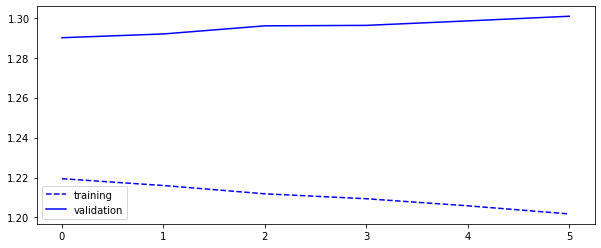

In [58]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.plot(history.history["loss"], label="training", color="blue", linestyle="dashed")
plt.plot(history.history["val_loss"], label="validation", color="blue")
plt.legend()
plt.show()